# Load

## Libs

In [1]:
suppressPackageStartupMessages({
    source('../libs.R')
    source('../utils.R')    
    source('../Figures/colors.R')    
    # source('../utils_mapping.R')
    source('../utils_plotting.R')
})


## data

In [2]:
ddres_costim <- readRDS('../../data/cache/stim_revisions_ddres_v1.rds')

In [3]:
cluster_names_df <- unique(dplyr::select(readRDS('../../data/cache/obj_fibroblasts/meta_data.rds'), Cluster, Cluster_name))

In [4]:
## Get pseudobulk expression to plot in heatmap 
obj_costim <- readRDS('../../data/cache/revision1_stim_object.rds')
pb_costim <- presto::collapse_counts(obj_costim$exprs_raw, obj_costim$meta_data, c('DonorID', 'Condition', 'Tissue'))

## Z-score within tissue 
pb_costim$exprs_scaled <- pb_costim$meta_data %>% split(.$Tissue) %>% map(function(.SD) {
    scaleData(pb_costim$exprs_norm[, rownames(.SD)], margin = 1, thresh = 5)
}) %>% 
    purrr::reduce(Matrix::cbind2)
pb_costim$exprs_scaled <- pb_costim$exprs_scaled[, colnames(pb_costim$exprs_norm)]
pb_costim$exprs_scaled[which(is.na(pb_costim$exprs_scaled))] <- 0

CAREFUL: get_norm makes very strong assumptions about data



In [5]:
obj_costim_fls <- readRDS('../../data/cache/revision1_stim_object_synovium.rds')
obj_costim_lung <- readRDS('../../data/cache/revision1_stim_object_lung.rds')

# Cell counts

In [6]:
# fig.size(4, 6)
# p_counts <- data.table(obj_costim$meta_data)[, .N, by = .(Condition, DonorID, Tissue)] %>% 
#     ggplot(aes(DonorID, N, fill = Condition)) + 
#         geom_bar(stat = 'identity', position = position_dodge()) + 
#         facet_grid(Tissue~., scales = 'free') + 
#         coord_flip() + 
#         scale_y_log10() + 
#         scale_fill_tableau() + 
#         geom_hline(yintercept = c(1e3), linetype = 2) + 
#         labs(y = 'Number cells') + 
#         NULL

# p_counts

# UMAPs

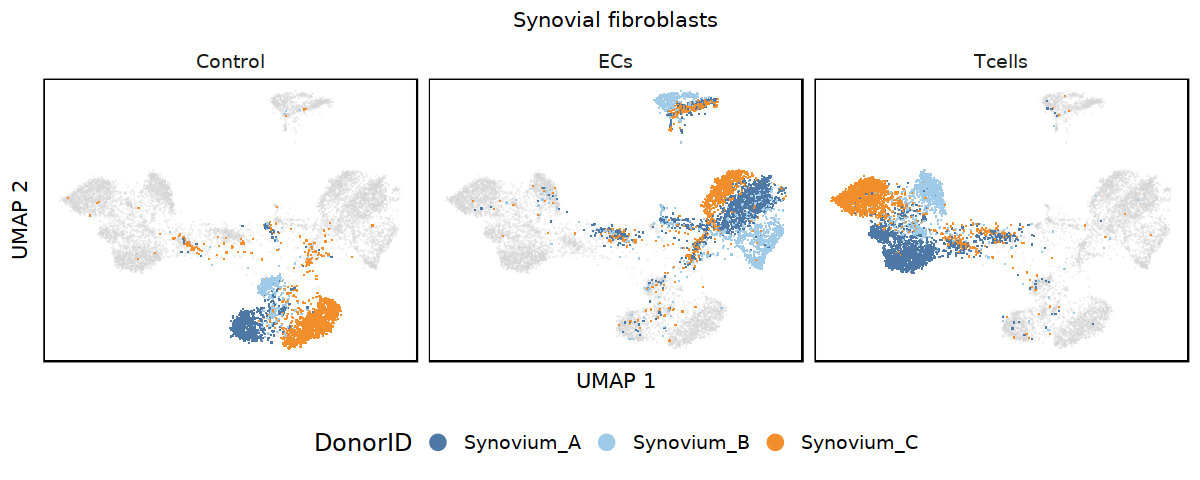

In [7]:
fig.size(4, 10)
p_umap_fls <- do_scatter(obj_costim_fls$U$embedding, obj_costim_fls$meta_data, 'DonorID', quo(Condition), do_labels=FALSE, no_guides=FALSE, nrow=1) + 
    labs(title = 'Synovial fibroblasts') + 
    theme(
        legend.position="bottom",
        plot.title = element_text(size=12),
        axis.ticks = element_blank(), 
        axis.text = element_blank(),
#         axis.title.x = element_blank()
    ) + 
    NULL
p_umap_fls

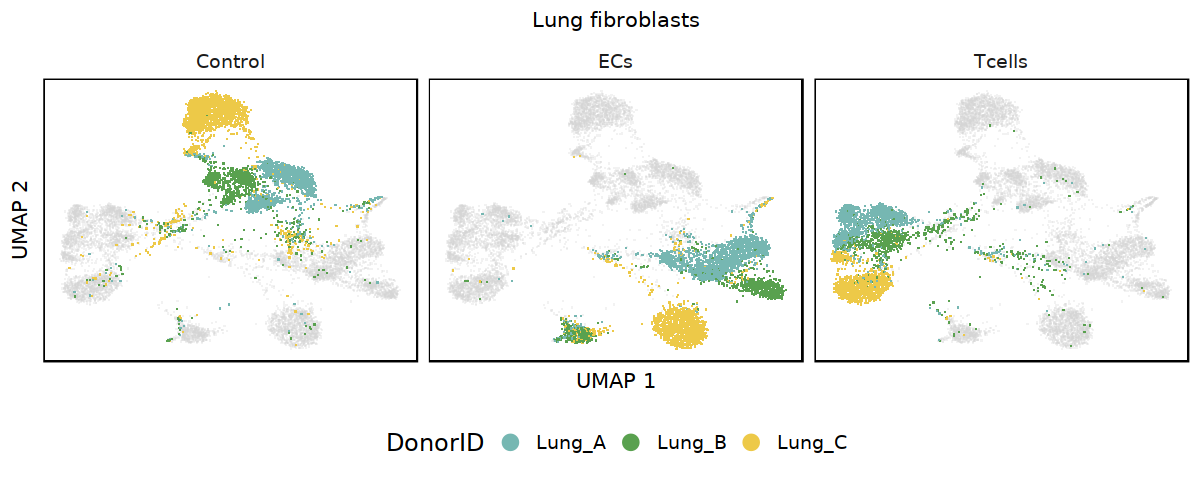

In [8]:
fig.size(4, 10)
p_umap_lung <- do_scatter(obj_costim_lung$U$embedding, obj_costim_lung$meta_data, 'DonorID', quo(Condition), do_labels=FALSE, no_guides=FALSE, palette_use = tableau_color_pal()(6)[4:6], nrow=1) + 
    labs(title = 'Lung fibroblasts') + 
    theme(
        legend.position="bottom",
        plot.title = element_text(size=12),
        axis.ticks = element_blank(), 
        axis.text = element_blank(),
#         axis.title.y = element_blank()
    ) + 
    NULL
p_umap_lung

# Condition-vs-condition

In [9]:
# data.table(ddres_costim)[padj < .05 & stat > 0, .SD[order(-log2FoldChange)][1:10], by = .(Tissue, Condition)]
#[, .N, by = .(Tissue, Condition)]
# data.table(ddres_costim)[padj < .05 & stat > 0, .SD[order(-stat)][1:10], by = .(Tissue, Condition)]

# genes_plot_tcells <- data.table(ddres_costim)[padj < .01 & log2FoldChange > 2, .SD[order(-stat)], by = .(Tissue, Condition)][Condition == 'Tcells', unique(feature)]
# genes_plot_ecs <- data.table(ddres_costim)[padj < .01 & log2FoldChange > 2, .SD[order(-stat)], by = .(Tissue, Condition)][Condition == 'ECs', unique(feature)]


genes_plot <- data.table(ddres_costim)[padj < .01 & log2FoldChange > 2, .SD[order(-stat)], by = .(Condition)][, unique(feature)]
# genes_highlight <- data.table(ddres_costim)[padj < .01 & log2FoldChange > 2, .SD[order(-stat)][1:5], by = .(Tissue, Condition)][, unique(feature)] 
# genes_highlight <- ddres_costim %>% 
#     subset(padj < .01 & log2FoldChange > 2) %>% 
#     dplyr::select(Tissue, Condition, feature, log2FoldChange) %>% 
#     tidyr::spread(Tissue, log2FoldChange) %>% 
#     subset(!is.na(lung) & !is.na(fls)) %>% 
#     split(.$Condition) %>% 
#     map(function(.SD) {
#         .SD %>% 
#             arrange(-(fls*lung)) %>% 
#             head(10)
#     }) %>% 
#     bind_rows() %>% 
#     with(unique(feature)) 

genes_highlight <- c('CXCL10', 'CXCL11', 'CCL19', 'IGFBP2', 'ZBTB16', 'CCND2')

# genes_highlight <- union(genes_highlight, c('CXCL10', 'CCL19', 'SPARC'))
row_o <- pb_costim$meta_data %>% arrange(Condition, Tissue) %>% rownames()
mat <- t(pb_costim$exprs_scaled[genes_plot, row_o])
rownames(mat) <- glue('{Tissue} {Condition}', .envir = pb_costim$meta_data[row_o, ])


In [10]:
anno_cols <- data.table(ddres_costim)[feature %in% genes_plot][, .(score = mean(log2FoldChange)), by = .(feature, Condition)][, .SD[order(-score)][1], by = feature][, .(feature, Condition)] %>% 
    data.frame() %>% 
    tibble::column_to_rownames('feature') %>% 
    arrange(Condition)
# anno_cols <- anno_cols[colnames(mat), , drop = FALSE]
mat <- mat[, rownames(anno_cols), drop = FALSE]

Joining, by = "feature"


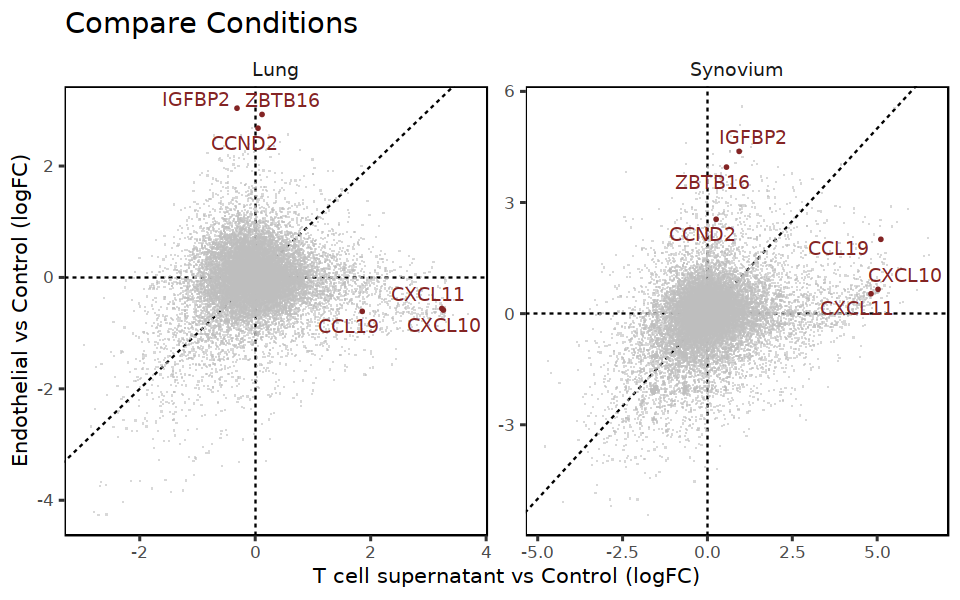

In [11]:
fig.size(5, 8)
plt_df <- ddres_costim %>% 
#     dplyr::select(Tissue, Condition, SCORE=stat, feature) %>% 
    dplyr::select(Tissue, Condition, SCORE=log2FoldChange, feature) %>% 
    tidyr::spread(Condition, SCORE, fill = 0) %>% 
    dplyr::mutate(Tissue = c(fls='Synovium', lung='Lung')[Tissue])

plt_df_highlight <- anno_cols %>%  
    tibble::rownames_to_column('feature') %>% 
    subset(feature %in% genes_highlight) %>% 
    left_join(plt_df) %>% 
    subset(
        (Condition == 'ECs' & ECs > 1.5) | (Condition == 'Tcells' & Tcells > 1.5)
    )

p_scatter_condition <- ggplot(plt_df, aes(Tcells, ECs)) +
    facet_wrap(~Tissue, scales = 'free') + 
    geom_hline(yintercept = 0, linetype = 2) + 
    geom_vline(xintercept = 0, linetype = 2) + 
    geom_abline(linetype = 2) + 
    geom_point(shape = '.', position = position_jitter(height = .05, width = .05), alpha = .6, color = 'grey') + 
    geom_point(
        data = plt_df_highlight, 
        shape = 16, size = 1, color = muted('red')
    ) + 
    geom_text_repel(
        data = plt_df_highlight, 
        aes(label = feature),
        max.overlaps = 20,
        color = muted('red')
    ) + 
    labs(title = 'Compare Conditions') + 
    scale_color_manual(values = palette_global[c('Yes', 'No')]) + 
    guides(color = 'none') + 
    labs(y = 'Endothelial vs Control (logFC)', x = 'T cell supernatant vs Control (logFC)') + 
    NULL

p_scatter_condition

In [12]:
genes_test <- data.table(ddres_costim)[pvalue < .01, unique(feature)]
ddres_costim %>% 
    subset(feature %in% genes_test) %>% 
#     dplyr::select(Tissue, Condition, SCORE=stat, feature) %>% 
    dplyr::select(Tissue, Condition, SCORE=log2FoldChange, feature) %>% 
    tidyr::spread(Condition, SCORE) %>% 
    split(.$Tissue) %>% 
    map(function(.SD) {
        broom::tidy(cor.test(~ ECs + Tcells, .SD, method = 'spearman'))
    }) %>% 
    bind_rows(.id = 'Condition')

Warning message in cor.test.default(x = c(0.336924045421549, -0.51877068026956, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = c(-2.33201850741734, 0.0045218212400813, :
“Cannot compute exact p-value with ties”


Condition estimate   statistic   p.value      
1 fls       0.25445169 72705389949 9.809093e-124
2 lung      0.06691165 90928912871  9.090207e-10
  method                          alternative
1 Spearman's rank correlation rho two.sided  
2 Spearman's rank correlation rho two.sided

# Focused corplot (T cells vs C11)

In [13]:
plt_df <- readRDS('../../data/cache/obj_fibroblasts/effects_nested.rds') %>% subset(Tissue %in% c('Lung', 'Synovium')) %>% 
    inner_join(
        ddres_costim %>% dplyr::mutate(Tissue = case_when(Tissue == 'fls' ~ 'Synovium', Tissue == 'lung' ~ 'Lung')), 
        by = c('feature', 'Tissue'), suffix = c('_cluster', '_culture')
    ) %>% 
    identity()
head(plt_df)

contrast    Cluster Tissue   feature beta     sigma     zscore  
1 9|Synovium  9       Synovium PI16    5.731668 0.6866517 8.347271
2 9|Synovium  9       Synovium PI16    5.731668 0.6866517 8.347271
3 11|Synovium 11      Synovium CCL19   5.085097 0.7209392 7.053433
4 11|Synovium 11      Synovium CCL19   5.085097 0.7209392 7.053433
5 9|Lung      9       Lung     IGFBP6  2.276067 0.3231950 7.042394
6 9|Lung      9       Lung     IGFBP6  2.276067 0.3231950 7.042394
  pvalue_cluster Condition baseMean     log2FoldChange lfcSE     stat      
1 3.492922e-17   ECs       3.306376e+02 -2.5252475     0.6435385 -3.9240037
2 3.492922e-17   Tcells    4.526671e+02 -0.2160162     0.2014937 -1.0720744
3 8.727806e-13   ECs       5.783177e-01  2.0064937     3.4692434  0.5783664
4 8.727806e-13   Tcells    4.012638e+00  5.1088985     1.7042391  2.9977593
5 9.448213e-13   ECs       2.031305e+04  1.5264710     0.1519470 10.0460766
6 9.448213e-13   Tcells    7.549233e+03 -0.0950169     0.1435970 -0.6616915
  pvalue_culture padj        
1 8.708940e-05   6.073487e-04
2 2.836866e-01   4.504826e-01
3 5.630168e-01             NA
4 2.719724e-03   9.927528e-03
5 9.559799e-24   1.310685e-21
6 5.081689e-01   6.903252e-01

Warning message:
“Removed 234 rows containing missing values (geom_point).”


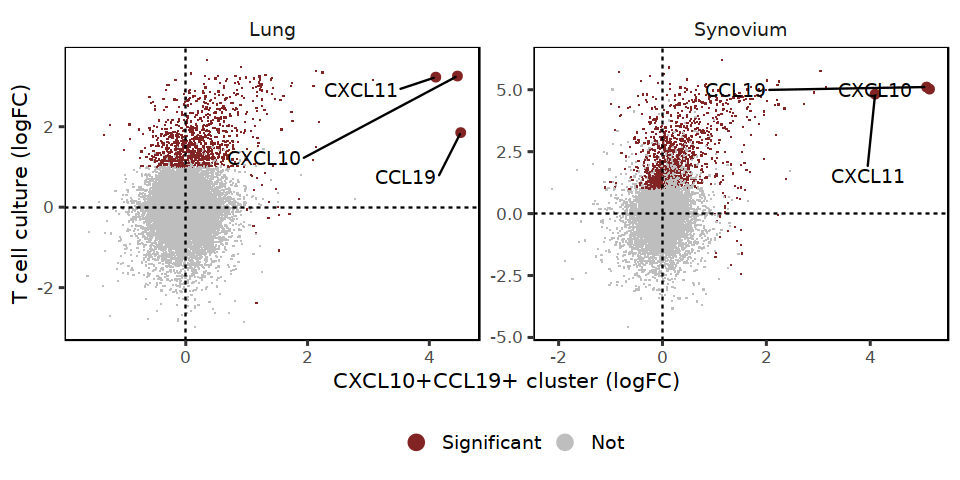

In [14]:
fig.size(4, 8)
p_culture_cor_focus <- plt_df %>% 
    dplyr::mutate(Label = case_when(
        (pvalue_cluster < .01 & (beta) > 1) | (pvalue_culture < .01 & (log2FoldChange) > 1) ~ 'Significant', 
        TRUE ~ 'Not'
    )) %>% 
    dplyr::mutate(Label = factor(Label, c('Significant', 'Not'))) %>% 
    subset(Cluster == '11' & Condition == 'Tcells') %>% 
    ggplot(aes(beta, log2FoldChange)) + 
        geom_point(shape = '.', aes(color = Label)) + 
        geom_hline(yintercept = 0, linetype = 2) + 
        geom_vline(xintercept = 0, linetype = 2) + 
        facet_wrap(~Tissue, scales = 'free') + 
#         guides(color = 'none') + 
#         scale_color_tableau() + 
        scale_color_manual(values = c(muted('red'), 'grey')) + 
        guides(color = guide_legend(override.aes = list(stroke = 1, alpha = 1, shape = 16, size = 4)), alpha = 'none') + 
        labs(x = 'CXCL10+CCL19+ cluster (logFC)', y = 'T cell culture (logFC)') + #, title = 'Comparison of relative expression signatures') + 
        theme(
            legend.title = element_blank(),
            legend.position='bottom'
        ) + 
        geom_point(
            data = . %>% subset(feature %in% c('CXCL10', 'CXCL11', 'CCL19')),             
            size = 2, color = muted('red')
        ) + 
        geom_text_repel(
            data = . %>% subset(feature %in% c('CXCL10', 'CXCL11', 'CCL19')), 
            aes(label = feature),
            max.overlaps = 20,
            box.padding = 1.5,
#             point.padding = 1
#             color = muted('red')
        ) + 
        NULL

p_culture_cor_focus

# Panels

Warning message:
“Removed 234 rows containing missing values (geom_point).”


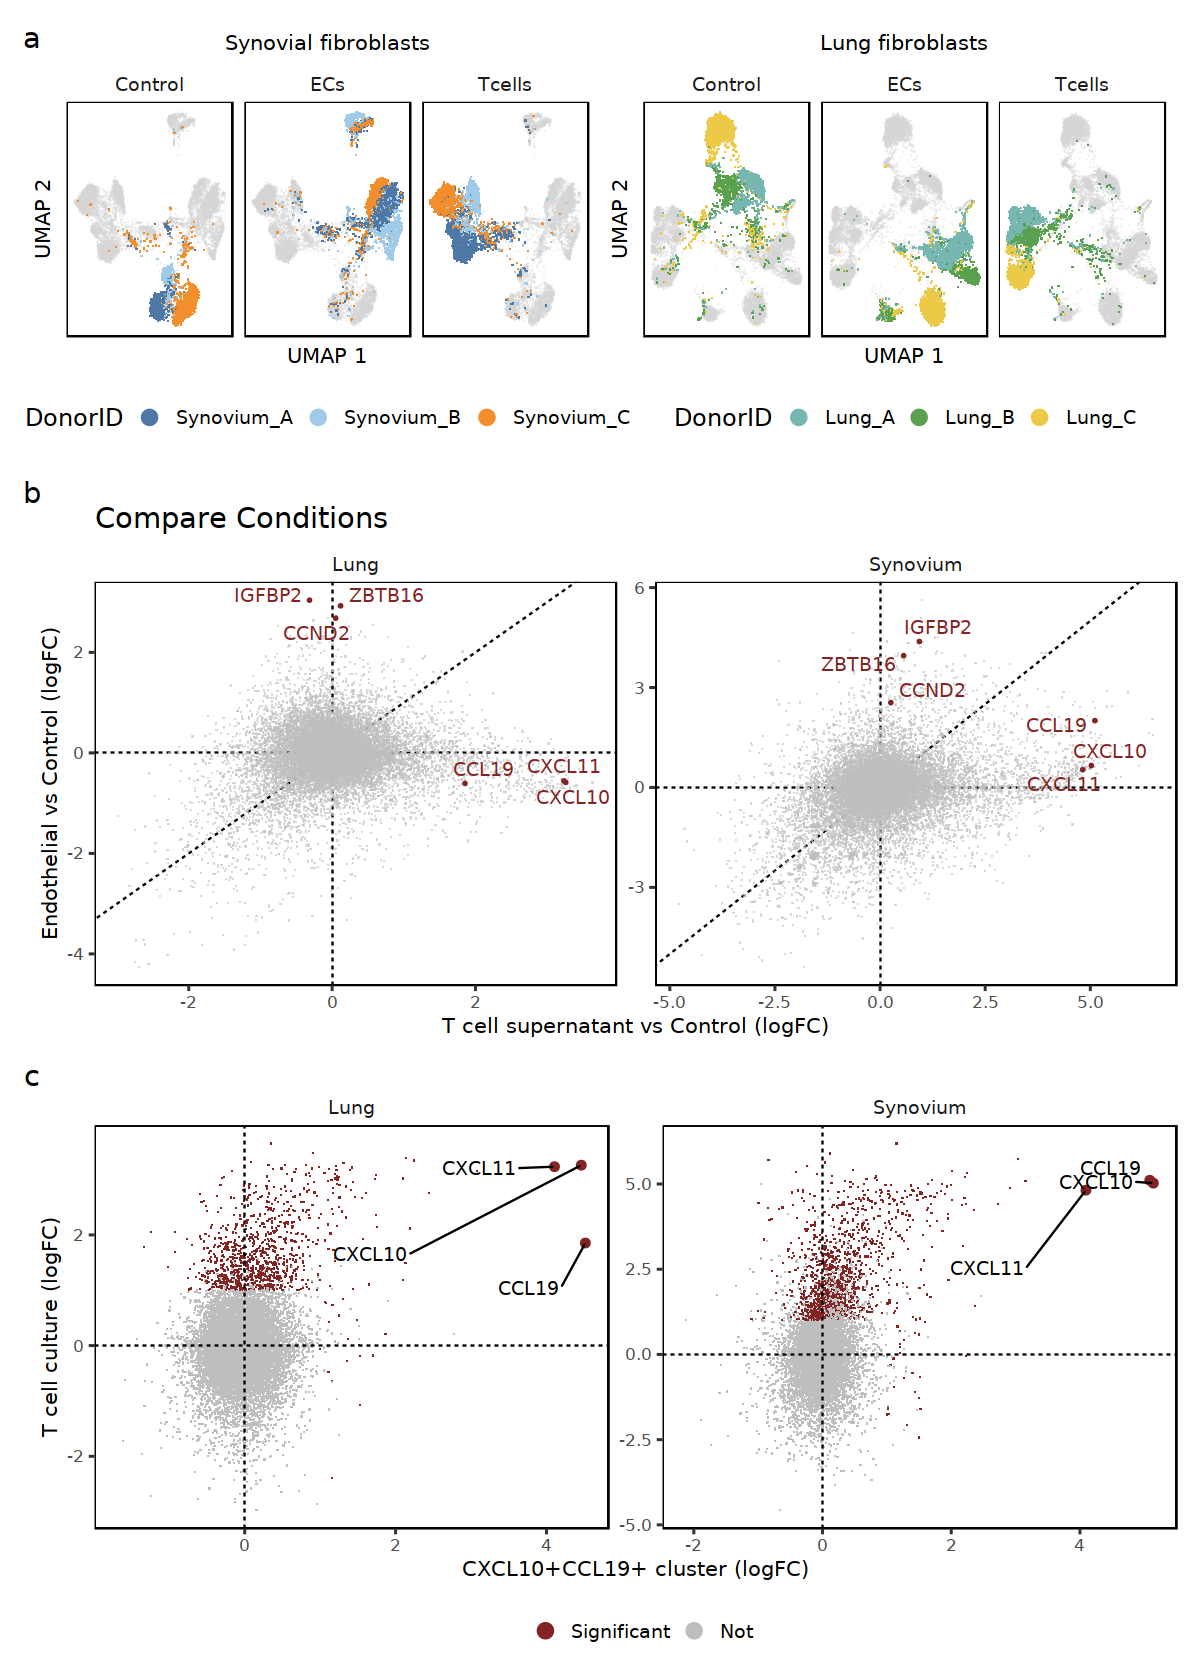

In [16]:
fig.size(14, 10)
p_final <- (
    # p_counts / 
    wrap_elements(full=p_umap_fls | p_umap_lung) / p_scatter_condition / p_culture_cor_focus
) + 
    plot_annotation(tag_levels = 'a')
p_final

In [17]:
ggsave(
    filename = '../../manuscript/figures/SuppFigure7.pdf', 
    plot = p_final,
    units = 'in', device = 'pdf', 
    height = 14, width = 10,
    useDingbats = FALSE
)


ggsave(
    filename = '../../manuscript/figures/SuppFigure7.png', 
    plot = p_final,
    units = 'in', device = 'png', 
    height = 14, width = 10
)


Warning message:
“Removed 234 rows containing missing values (geom_point).”
Warning message:
“Removed 234 rows containing missing values (geom_point).”
